In [61]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Data Explanation 

1. The first column shows time and date range (from march of 2017 until september of 2017). 
  
  
2. Some columns were sampled every 20 second. Others were sampled on a hourly base.


3. The second and third columns are quality measures of the iron ore pulp right before it is fed into the flotation plant. 


4. Column 4 until column 8 are the most important variables that impact in the ore quality in the end of the process. 


5. From column 9 until column 22, we can see process data (level and air flow inside the flotation columns, which also impact in ore quality. 


6. The last two columns are the final iron ore pulp quality measurement from the lab.


7. Target is to predict the last column, which is the % of silica in the iron ore concentrate.


General comments:

1. Column % Iron Concentrate is correlated to % Silica Concentrate and represents dataleakage. 


2. However past samplings of % Silica and % Iron Concentrate are not leakage as they inform process operations and past information that can influence current yield


3. The above represents a regression problem 


In [47]:
df = pd.read_csv('../../data/raw/miningprocess_flotation_plant_database.csv.zip',parse_dates=['date'] )

### Exploratory Data Analysis

In [48]:
# Columns 

# 'date' ------------------------------------> Need to check sampling rate changes accross time and investigate

# '% Iron Feed' -----------------------------> Need to understand relationship wrt to % Silica Feed

# '% Silica Feed'---------------------------->

# 'Starch Flow'------------------------------>

# 'Amina Flow'------------------------------->

# 'Ore Pulp Flow'---------------------------->

# 'Ore Pulp pH'------------------------------> Need to treat as log scale potentially + worry about noise on instrument if needed

# 'Ore Pulp Density'-------------------------> Potentially inaccurate measurement 

# 'Flotation Column 02 Air Flow'------------>

# 'Flotation Column 03 Air Flow'------------>

# 'Flotation Column 04 Air Flow'------------>

# 'Flotation Column 05 Air Flow'------------>

# 'Flotation Column 06 Air Flow'------------>

# 'Flotation Column 07 Air Flow'------------> How are these correlated? Are these at the same level or measured at different points

# 'Flotation Column 01 Level'---------------->How are these correlated? Are these at the same level or measured at different points

# 'Flotation Column 02 Level'---------------->How are these correlated? Are these at the same level or measured at different points

# 'Flotation Column 03 Level'---------------->How are these correlated? Are these at the same level or measured at different points

# 'Flotation Column 04 Level'---------------->How are these correlated? Are these at the same level or measured at different points

# 'Flotation Column 05 Level'---------------->How are these correlated? Are these at the same level or measured at different points

# 'Flotation Column 06 Level'---------------->How are these correlated? Are these at the same level or measured at different points

# 'Flotation Column 07 Level'---------------->How are these correlated? Are these at the same level or measured at different points

# '% Iron Concentrate'-----------------------> Correlated with % Silica Concentrate

# '% Silica Concentrate'---------------------> Final target column

### Datetime Analysis

In [49]:
# find minimum and maximum dates

df.date.min(),df.date.max()

(Timestamp('2017-03-10 01:00:00'), Timestamp('2017-09-09 23:00:00'))

In [50]:
# understand the sampling rate across the period

counts = df.groupby('date').count()

# < 180 implies there are missing 20s points 

counts[counts['% Iron Feed'] < 180]

# below indicates that there are two hours with less than 20s sampling intervals

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:00:00,174,174,174,174,174,174,174,174,174,174,...,174,174,174,174,174,174,174,174,174,174
2017-04-10 00:00:00,179,179,179,179,179,179,179,179,179,179,...,179,179,179,179,179,179,179,179,179,179


In [52]:
# get a series of unique hourly timestamps

hours = pd.Series(df['date'].unique())

hours.index = hours

len(hours)

4097

In [63]:
# create a date time index from the first to the last hour included in the date column

date_range = pd.date_range(start=df.iloc[0,0], end='2017-09-09 23:59:40', freq='20S')

# remove first couple observations consistent with the counts exploration above

date_range = date_range[6:]

date_range[-5:]

DatetimeIndex(['2017-09-09 23:58:20', '2017-09-09 23:58:40',
               '2017-09-09 23:59:00', '2017-09-09 23:59:20',
               '2017-09-09 23:59:40'],
              dtype='datetime64[ns]', freq='20S')

In [56]:
# create lists from both the hours series and the new datetime index

hours_list = hours.index.format()

print(hours_list[:5])

seconds_list = date_range.format()

['2017-03-10 01:00:00', '2017-03-10 02:00:00', '2017-03-10 03:00:00', '2017-03-10 04:00:00', '2017-03-10 05:00:00']
['2017-03-10 01:02:00', '2017-03-10 01:02:20', '2017-03-10 01:02:40', '2017-03-10 01:03:00', '2017-03-10 01:03:20']


In [57]:
new_index = []

for idx in seconds_list:
    
    if (idx[:13] + ':00:00') in hours_list:
        
        new_index.append(idx)

#remove the one missing interval within the hour which we found earlier using the counts

new_index.remove('2017-04-10 00:00:00')

['2017-09-09 23:53:20',
 '2017-09-09 23:53:40',
 '2017-09-09 23:54:00',
 '2017-09-09 23:54:20',
 '2017-09-09 23:54:40',
 '2017-09-09 23:55:00',
 '2017-09-09 23:55:20',
 '2017-09-09 23:55:40',
 '2017-09-09 23:56:00',
 '2017-09-09 23:56:20',
 '2017-09-09 23:56:40',
 '2017-09-09 23:57:00',
 '2017-09-09 23:57:20',
 '2017-09-09 23:57:40',
 '2017-09-09 23:58:00',
 '2017-09-09 23:58:20',
 '2017-09-09 23:58:40',
 '2017-09-09 23:59:00',
 '2017-09-09 23:59:20',
 '2017-09-09 23:59:40']

In [59]:
df['datetime_seconds'] = new_index 

# df = df.loc[:, df.columns[:-1]]

df.rename(columns={'date': 'datetime_hours'}, inplace=True)

df.head()

,datetime_hours,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,datetime_seconds
0,2017-03-10 01:00:00,"55,2","16,98","3019,53","557,434","395,713","10,0664","1,74","249,214","253,235",...,"457,396","432,962","424,954","443,558","502,255","446,37","523,344","66,91","1,31",2017-03-10 01:02:00
1,2017-03-10 01:00:00,"55,2","16,98","3024,41","563,965","397,383","10,0672","1,74","249,719","250,532",...,"451,891","429,56","432,939","448,086","496,363","445,922","498,075","66,91","1,31",2017-03-10 01:02:20
2,2017-03-10 01:00:00,"55,2","16,98","3043,46","568,054","399,668","10,068","1,74","249,741","247,874",...,"451,24","468,927","434,61","449,688","484,411","447,826","458,567","66,91","1,31",2017-03-10 01:02:40
3,2017-03-10 01:00:00,"55,2","16,98","3047,36","568,665","397,939","10,0689","1,74","249,917","254,487",...,"452,441","458,165","442,865","446,21","471,411","437,69","427,669","66,91","1,31",2017-03-10 01:03:00
4,2017-03-10 01:00:00,"55,2","16,98","3033,69","558,167","400,254","10,0697","1,74","250,203","252,136",...,"452,441","452,9","450,523","453,67","462,598","443,682","425,679","66,91","1,31",2017-03-10 01:03:20


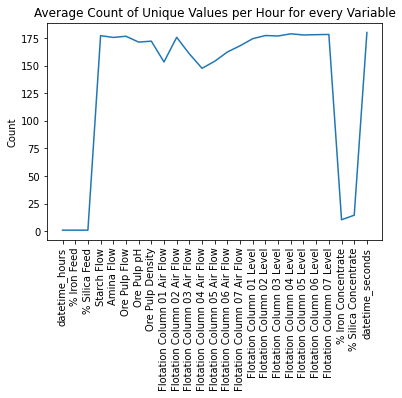

In [60]:
unique_avg = []

for col in df.columns:
    
    unique_avg.append(df.groupby('datetime_hours').apply(lambda x: len(x[col].unique())).mean())

plt.plot(np.arange(len(unique_avg)), unique_avg)
plt.title('Average Count of Unique Values per Hour for every Variable')
plt.ylabel('Count')
plt.xticks(list(range(len(unique_avg))), list(df.columns), rotation='vertical')
plt.show()

In [44]:
df

,datetime_hours,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,"55,2","16,98","3019,53","557,434","395,713","10,0664","1,74","249,214","253,235",...,"250,884","457,396","432,962","424,954","443,558","502,255","446,37","523,344","66,91","1,31"
1,2017-03-10 01:00:00,"55,2","16,98","3024,41","563,965","397,383","10,0672","1,74","249,719","250,532",...,"248,994","451,891","429,56","432,939","448,086","496,363","445,922","498,075","66,91","1,31"
2,2017-03-10 01:00:00,"55,2","16,98","3043,46","568,054","399,668","10,068","1,74","249,741","247,874",...,"248,071","451,24","468,927","434,61","449,688","484,411","447,826","458,567","66,91","1,31"
3,2017-03-10 01:00:00,"55,2","16,98","3047,36","568,665","397,939","10,0689","1,74","249,917","254,487",...,"251,147","452,441","458,165","442,865","446,21","471,411","437,69","427,669","66,91","1,31"
4,2017-03-10 01:00:00,"55,2","16,98","3033,69","558,167","400,254","10,0697","1,74","250,203","252,136",...,"248,928","452,441","452,9","450,523","453,67","462,598","443,682","425,679","66,91","1,31"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737448,2017-09-09 23:00:00,"49,75","23,2","2710,94","441,052","386,57","9,62129","1,65365","302,344","298,786",...,"313,695","392,16","430,702","872,008","418,725","497,548","446,357","416,892","64,27","1,71"
737449,2017-09-09 23:00:00,"49,75","23,2","2692,01","473,436","384,939","9,62063","1,65352","303,013","301,879",...,"236,7","401,505","404,616","864,409","418,377","506,398","372,995","426,337","64,27","1,71"
737450,2017-09-09 23:00:00,"49,75","23,2","2692,2","500,488","383,496","9,61874","1,65338","303,662","307,397",...,"225,879","408,899","399,316","867,598","419,531","503,414","336,035","433,13","64,27","1,71"
737451,2017-09-09 23:00:00,"49,75","23,2","1164,12","491,548","384,976","9,61686","1,65324","302,55","301,959",...,"308,115","405,107","466,832","876,591","407,299","502,301","340,844","433,966","64,27","1,71"
